In [1]:
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import *
import urllib
from io import BytesIO
from PIL import Image

In [2]:
fix_df = pd.read_csv('./fix_age_study.csv')

In [3]:
fix_df.head()

,Unnamed: 0,SUBJECTINDEX,age,answer,catch,category,dataset_nr,end,filenumber,fix,on_image,patchpos,start,trial,valid,x,y
0,0,1.0,2.0,1.0,0.0,7.0,0.0,377.0,17.0,1.0,1.0,1166.0,101.0,1.0,1.0,708.86950,402.91230
1,1,1.0,2.0,1.0,0.0,7.0,0.0,585.0,17.0,2.0,1.0,482.0,417.0,1.0,1.0,495.03134,451.73110
2,2,1.0,2.0,1.0,0.0,7.0,0.0,961.0,17.0,3.0,1.0,1166.0,651.0,1.0,1.0,1095.33590,276.77325
3,3,1.0,2.0,1.0,0.0,7.0,0.0,1201.0,17.0,4.0,1.0,482.0,1015.0,1.0,1.0,686.60760,477.21127
4,4,1.0,2.0,1.0,0.0,7.0,0.0,1423.0,17.0,5.0,1.0,1166.0,1235.0,1.0,1.0,811.72290,468.97660


In [4]:
fix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105813 entries, 0 to 105812
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    105813 non-null  int64  
 1   SUBJECTINDEX  105813 non-null  float64
 2   age           105813 non-null  float64
 3   answer        105813 non-null  float64
 4   catch         105813 non-null  float64
 5   category      105813 non-null  float64
 6   dataset_nr    105813 non-null  float64
 7   end           105813 non-null  float64
 8   filenumber    105813 non-null  float64
 9   fix           105813 non-null  float64
 10  on_image      105813 non-null  float64
 11  patchpos      105813 non-null  float64
 12  start         105813 non-null  float64
 13  trial         105813 non-null  float64
 14  valid         105813 non-null  float64
 15  x             105813 non-null  float64
 16  y             105813 non-null  float64
dtypes: float64(16), int64(1)
memory usage: 13.7 MB


In [70]:
fix_df.SUBJECTINDEX.count()

105813

In [37]:
(
    fix_df
    .groupby('SUBJECTINDEX')
    .trial
    .nunique()
    .agg(['mean', 'std'])
)

mean    127.431034
std       0.993171
Name: trial, dtype: float64

In [7]:
fix_df.answer.value_counts(normalize=True)

1.0    0.511374
0.0    0.488626
Name: answer, dtype: float64

In [8]:
fix_df.category.value_counts(normalize=True)

8.0     0.277130
10.0    0.259278
7.0     0.253183
11.0    0.210409
Name: category, dtype: float64

In [9]:
fix_df.age.value_counts(normalize=True)

1.0    0.410356
2.0    0.322229
0.0    0.267415
Name: age, dtype: float64

In [10]:
fix_df.catch.value_counts(normalize=True)

0.0    0.506582
1.0    0.493418
Name: catch, dtype: float64

In [11]:
fix_df.loc[:, "str_category"] = fix_df["category"].replace({
    7:"natural", 
    8:"urban",
    10:"fractals",
    11:"pink_noise"
})

fix_df.loc[:, "age_category"] = fix_df["age"].replace({
    0:"child", 
    1:"teen",
    2:"old",
})

fix_df['is_accurate'] = fix_df.catch != fix_df.answer

In [12]:
fix_df.is_accurate.value_counts(normalize=True)

True     0.805875
False    0.194125
Name: is_accurate, dtype: float64

In [13]:
fix_df.groupby(['str_category']).is_accurate.mean()

str_category
fractals      0.868744
natural       0.880664
pink_noise    0.631333
urban         0.811247
Name: is_accurate, dtype: float64

In [23]:
df_cleaned = fix_df.loc[
    (fix_df.start>=0) & (fix_df.start<5000) & (fix_df.end<=5000), :
]

df_cleaned.loc[:, "duration"] = (
    df_cleaned.loc[:, "end"] - df_cleaned.loc[:, "start"]
)

df_cleaned = df_cleaned.query('duration > 0')

/var/folders/g8/ypnc8p1504z5jmrpjc4jzyw80000gn/T/ipykernel_38871/179736500.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, "duration"] = (


In [24]:
def mad_outlier(data, threshold=3.5):
    """ Median Absolute deviation based outlier detection.
    Returns a booelan mask (True if z > threshold, else False)."""
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_score = 0.6745 * (data - median) / mad

    return modified_z_score > threshold

# TODO: Remove outliers with respect to fixation duration
df_cleaned.loc[:, 'is_outlier'] = mad_outlier(df_cleaned.duration)

df_cleaned.is_outlier.value_counts(normalize=True)

False    0.963096
True     0.036904
Name: is_outlier, dtype: float64

In [38]:
def mad_outlier(data, threshold=3.5):
    """ Median Absolute deviation based outlier detection.
    Returns a booelan mask (True if z > threshold, else False)."""
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_score = 0.6745 * (data - median) / mad

    return modified_z_score

df_cleaned['mad_dist'] = mad_outlier(df_cleaned.duration)

[(-5.0, 10.0)]

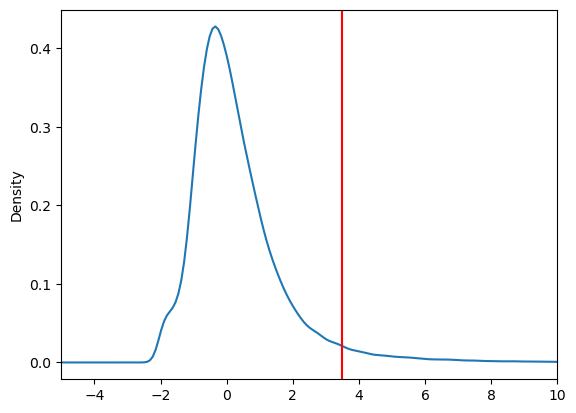

In [42]:
ax = df_cleaned.mad_dist.plot.kde()
ax.axvline(3.5, color='r')
ax.set(xlim=(-5, 10))

In [25]:
df_cleaned.head()

,Unnamed: 0,SUBJECTINDEX,age,answer,catch,category,dataset_nr,end,filenumber,fix,...,start,trial,valid,x,y,str_category,age_category,is_accurate,duration,is_outlier
0,0,1.0,2.0,1.0,0.0,7.0,0.0,377.0,17.0,1.0,...,101.0,1.0,1.0,708.86950,402.91230,natural,old,True,276.0,False
1,1,1.0,2.0,1.0,0.0,7.0,0.0,585.0,17.0,2.0,...,417.0,1.0,1.0,495.03134,451.73110,natural,old,True,168.0,False
2,2,1.0,2.0,1.0,0.0,7.0,0.0,961.0,17.0,3.0,...,651.0,1.0,1.0,1095.33590,276.77325,natural,old,True,310.0,False
3,3,1.0,2.0,1.0,0.0,7.0,0.0,1201.0,17.0,4.0,...,1015.0,1.0,1.0,686.60760,477.21127,natural,old,True,186.0,False
4,4,1.0,2.0,1.0,0.0,7.0,0.0,1423.0,17.0,5.0,...,1235.0,1.0,1.0,811.72290,468.97660,natural,old,True,188.0,False


In [26]:
df_cleaned['log_duration'] = np.log(df_cleaned['duration'])
df_cleaned['inv_duration'] = 1/df_cleaned['duration']

In [27]:
df_cleaned.isna().sum()

Unnamed: 0      0
SUBJECTINDEX    0
age             0
answer          0
catch           0
category        0
dataset_nr      0
end             0
filenumber      0
fix             0
on_image        0
patchpos        0
start           0
trial           0
valid           0
x               0
y               0
str_category    0
age_category    0
is_accurate     0
duration        0
is_outlier      0
log_duration    0
inv_duration    0
dtype: int64

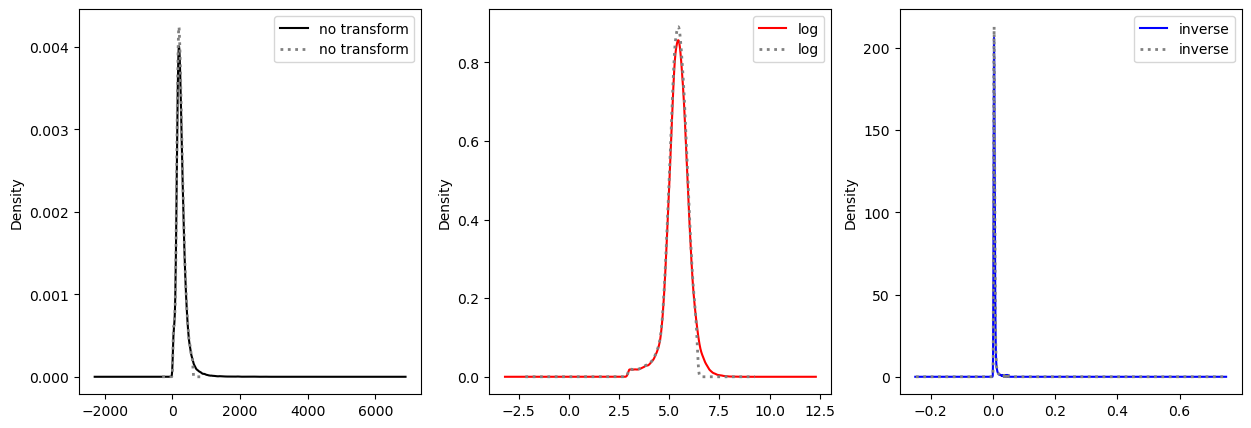

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0] = df_cleaned.duration.plot(kind='kde', color='k', label='no transform', ax=ax[0])
ax[0] = df_cleaned.query('is_outlier==0').duration.plot(kind='kde',  ls=':', lw=2, color='grey', label='no transform', ax=ax[0])


ax[1] = df_cleaned.log_duration.plot(kind='kde', color='r', label='log', ax=ax[1])
ax[1] = df_cleaned.query('is_outlier==0').log_duration.plot(kind='kde', ls=':', lw=2, color='grey', label='log', ax=ax[1])


ax[2] = df_cleaned.inv_duration.plot(kind='kde', color='b', label='inverse', ax=ax[2])
ax[2] = df_cleaned.query('is_outlier==0').inv_duration.plot(kind='kde',  ls=':', lw=2, color='grey', label='inverse', ax=ax[2])



ax[0].legend()
ax[1].legend()
ax[2].legend()

# ax.set(xlim=(-100, 400), xlabel='fixation duration')

In [46]:

df_cleaned = df_cleaned.query('x >= 0 and x <= 1280 and y>=0 and y<=960')

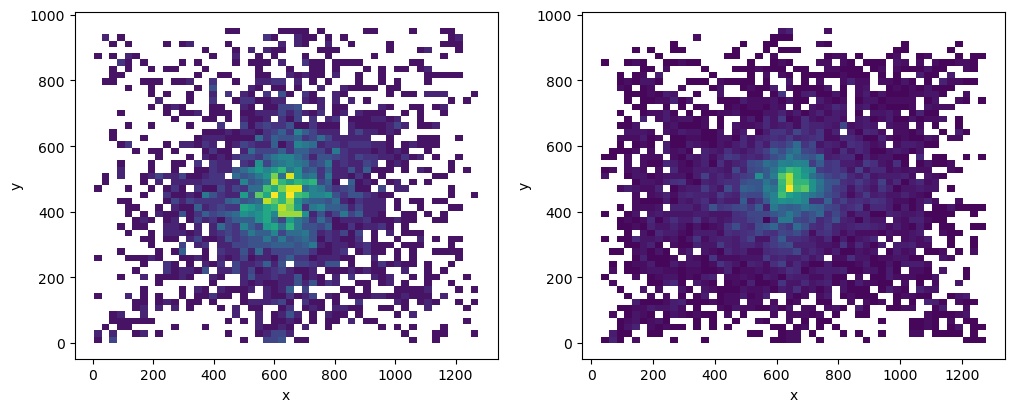

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

tmpdf = df_cleaned.query('age_category=="child" and is_outlier==False and str_category=="pink_noise"')
sns.histplot(
    data=tmpdf, x='x', y='y',
    bins=50, cmap='viridis',
    ax=ax[0]
);

tmpdf = df_cleaned.query('age_category=="old" and is_outlier==False and str_category=="pink_noise"')
sns.histplot(
    data=tmpdf, x='x', y='y',
    bins=50, cmap='viridis',
    ax=ax[1]
);

In [74]:
# fix_count_df = 
(
    df_cleaned
    .query('is_outlier == False')
    .groupby(['SUBJECTINDEX', 'trial', 'str_category', 'age_category'])
    .fix
    .nunique()
    .reset_index()
    .groupby(['SUBJECTINDEX', 'str_category', 'age_category'])
    .fix
    .mean()
    .reset_index()
    .groupby(['str_category', 'age_category'])
    .fix
    .mean()
    .reset_index()
)

# fix_count_df
    

,str_category,age_category,fix
0,fractals,child,11.715289
1,fractals,old,14.733456
2,fractals,teen,13.485712
3,natural,child,10.661343
4,natural,old,14.696691
5,natural,teen,13.513587
6,pink_noise,child,6.606241
7,pink_noise,old,12.793821
8,pink_noise,teen,11.442703
9,urban,child,12.497756


<AxesSubplot:xlabel='str_category', ylabel='fix'>

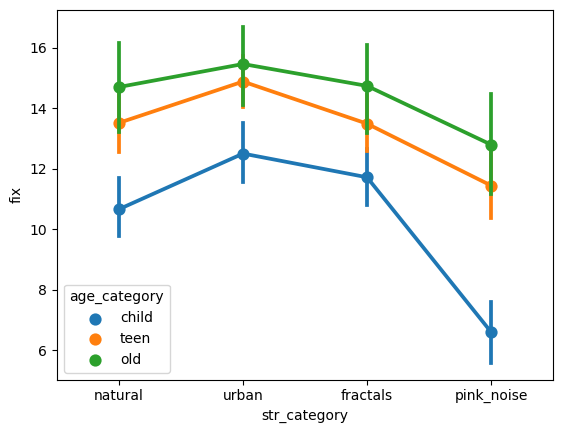

In [69]:
sns.pointplot(
    data=fix_count_df,
    x='str_category',
    y='fix',
    hue='age_category',
    hue_order=['child', 'teen', 'old'],
    order = ['natural', 'urban', 'fractals', 'pink_noise']
)